Implementation steps:

1. Set up our helper classes (`ETL`, `PredictAndForecast`, `Evaluate`). ✅
2. Implement a transformer architecture for timeseries regression.✅
3. Train our models and use them for inference, measuring performance.✅
4. Evaluate our models' performances. ✅
5. Visualize our predictions.✅

In [ ]:
#pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
import matplotlib.pyplot as plt
import yfinance as yf
from keras import layers
import time
import timeit
import seaborn as sns
#sns.set_style('whitegrid')
#plt.style.use("fivethirtyeight")
#%matplotlib inline

## 1. Helper Classes

In [ ]:
class ETL:
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.test_size = test_size
        self.period = period
        self.n_input = n_input
        self.timestep = timestep
        self.df = self.extract_historic_data()
        self.train, self.test = self.etl()
        self.x_train, self.y_train = self.to_supervised(self.train)
        self.x_test, self.y_test = self.to_supervised(self.test)

    def extract_historic_data(self) -> pd.Series:
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period, interval="1d")
        scaler = MinMaxScaler(feature_range=(0,1))
        history['Close'] = scaler.fit_transform(history['Close'].values.reshape(-1,1))
        return history['Close']

    def split_data(self) -> tuple:
        data = self.extract_historic_data()
        if len(data) != 0:
            train_index = round(len(data) * (1 - self.test_size))
            train = data[:train_index]
            test = data[train_index:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> tuple:
        train_reminder = train.shape[0] % self.timestep
        test_reminder = test.shape[0] % self.timestep
        if train_reminder != 0:
            train = train[train_reminder:]
        if test_reminder != 0:
            test = test[test_reminder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple:
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, data, n_out=5) -> tuple:
        data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
        x, y = [], []
        in_start = 0

        for _ in range(len(data)):
            in_end = in_start + self.n_input
            out_end = in_end + n_out

            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                x.append(x_input)
                y.append(data[in_end:out_end, 0])
            in_start += 1

        return np.array(x), np.array(y)

In [ ]:
class PredictAndForecast:

  def __init__(self, model, train, test, n_input=5) -> None:
    self.model = model
    self.train = train
    self.test = test
    self.n_input = n_input
    self.predictions = self.get_predictions()

  def forecast(self, history) -> np.array:
    data = np.array(history)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
    input_x = data[-self.n_input:, :]
    input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
    yhat = self.model.predict(input_x, verbose = 0)
    yhat = yhat[0]
    return yhat

  def get_predictions(self) -> np.array:
    history = [x for x in self.train]
    predictions = []
    for i in range(len(self.test)):
      yhat_sequence = self.forecast(history)
      predictions.append(yhat_sequence)
      history.append(self.test[i, :])
    return np.array(predictions)

In [ ]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

In [ ]:
data = ETL('HPG')

## 2. Implementing a Transformer

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout = 0, epsilon = 1e-6, attention_axes = None, kernel_size = 1):

  x = layers.LayerNormalization(epsilon = epsilon)(inputs)
  x = layers.MultiHeadAttention(key_dim = head_size, num_heads = num_heads, dropout = dropout, attention_axes = attention_axes)(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

  x = layers.LayerNormalization(epsilon = epsilon)(inputs)
  x = layers.Conv1D(filters = ff_dim, kernel_size = kernel_size, activation = "relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters = inputs.shape[-1], kernel_size = kernel_size)(x)

  return x + res

def build_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout = 0, mlp_dropout = 0, attention_axes = None, epsilon = 1e-6, kernel_size = 1):

  n_timesteps, n_features, n_outputs = 5, 1, 5
  inputs = tf.keras.Input(shape = (n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x  = transformer_encoder(x, head_size = head_size, num_heads= num_heads, ff_dim = ff_dim, dropout = dropout, attention_axes = attention_axes, kernel_size = kernel_size, epsilon = epsilon)

  x = layers.GlobalAveragePooling1D(data_format = 'channels_first')(x)
  for dim in mlp_units:
    x = layers.Dense(units = dim, activation = 'relu')(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [ ]:
tranformer = build_transformer(head_size = 128, num_heads = 4, ff_dim = 2, num_trans_blocks = 4, mlp_units = [256], dropout = 0.10, attention_axes = 1)


In [ ]:
tranformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_9 (Lay  (None, 5, 1)                 2         ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_8 (Lay  (None, 5, 1)                 2         ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                            

In [ ]:
def fit_transformer(tranformer: tf.keras.Model):
  tranformer.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['mae', 'mape'])
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 10, restore_best_weights = True)]
  start = time.time()
  hist = tranformer.fit(data.x_train, data.y_train, batch_size = 32, epochs = 25, verbose = 1, callbacks = callbacks)
  print(time.time() - start)
  return hist

In [ ]:
hist = fit_transformer(tranformer)

Epoch 1/25
76/76 [==============================] - 10s 27ms/step - loss: 1.0592e-04 - mae: 0.0067 - mape: 2555.4495
Epoch 2/25
76/76 [==============================] - 3s 41ms/step - loss: 9.1724e-05 - mae: 0.0061 - mape: 1809.1316
Epoch 3/25
76/76 [==============================] - 3s 34ms/step - loss: 9.0904e-05 - mae: 0.0059 - mape: 1949.5920
Epoch 4/25
76/76 [==============================] - 2s 26ms/step - loss: 9.6906e-05 - mae: 0.0064 - mape: 2115.2463
Epoch 5/25
76/76 [==============================] - 2s 25ms/step - loss: 1.1647e-04 - mae: 0.0074 - mape: 1562.1683
Epoch 6/25
76/76 [==============================] - 2s 26ms/step - loss: 1.0314e-04 - mae: 0.0066 - mape: 2455.4609
Epoch 7/25
76/76 [==============================] - 2s 26ms/step - loss: 9.3151e-05 - mae: 0.0060 - mape: 1949.4875
Epoch 8/25
76/76 [==============================] - 3s 35ms/step - loss: 8.9910e-05 - mae: 0.0060 - mape: 1080.3044
Epoch 9/25
76/76 [==============================] - 3s 39ms/step - loss

In [ ]:
start = time.time()
transformer_preds = PredictAndForecast(tranformer, data.train, data.test)
print(time.time() - start)

11.451569557189941


# 3. Evaluating on test set

In [ ]:
transformer_evals = Evaluate(data.test, transformer_preds.predictions)

In [ ]:
transformer_evals.mape

0.9959665423303518

In [ ]:
transformer_evals.var_ratio

0.9999852445264599

# 4. Visualizing

In [ ]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='HPG stock Price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')
  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  if image_path != None:
    imagedir = '/content/drive/MyDrive/Colab Notebooks/images'
    plt.savefig(f'{imagedir}/{image_path}.png')
  plt.show()

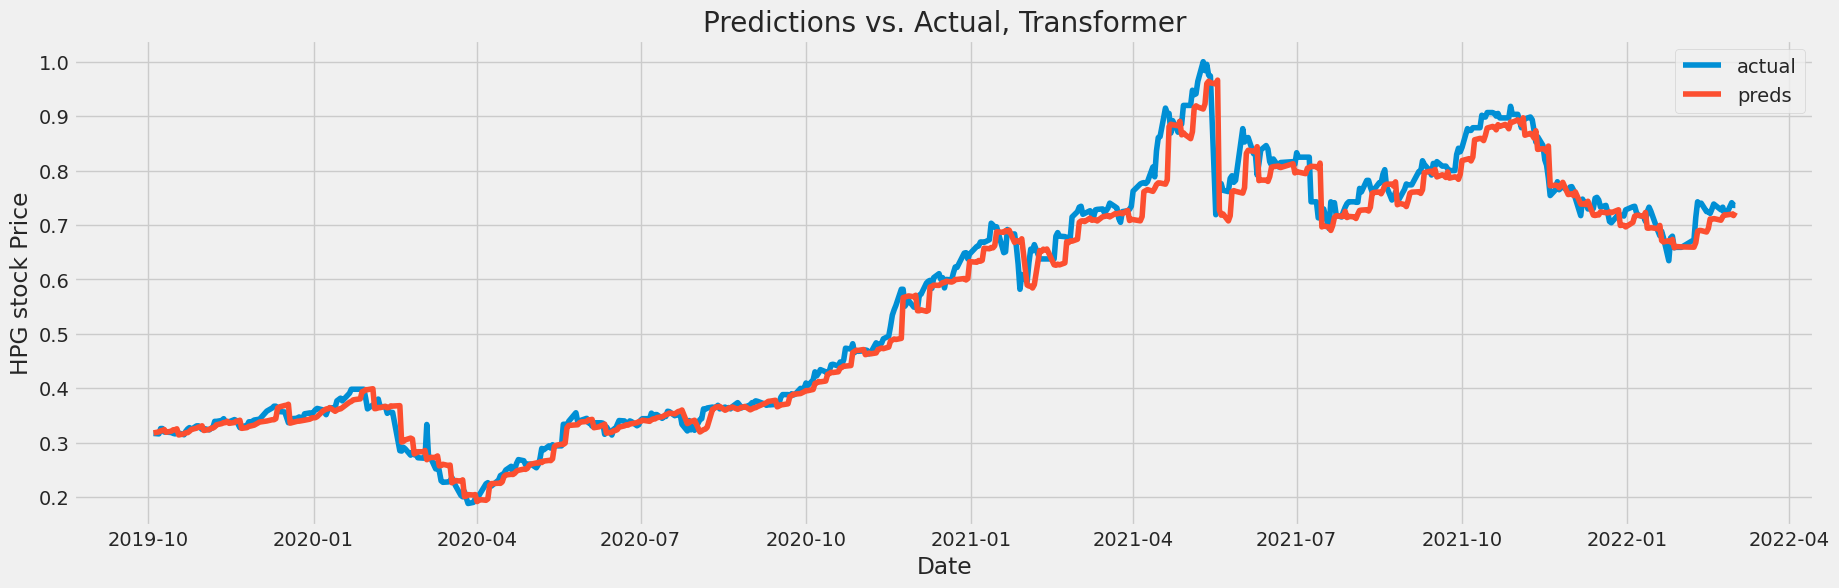

In [ ]:
plot_results(data.test, transformer_preds.predictions, data.df, title_suffix='Transformer')